# Ordering Kewords using Pretrained Embeddings

We use th FastText Bag Of Tricks model pretrained on **Common Crawl** and **Wikipedia** to generate the word embeddings. <br>
Link to the paper [here](https://arxiv.org/pdf/1607.01759.pdf). <br>
Link to the 157 pretrained embeddings [here](https://fasttext.cc/docs/en/crawl-vectors.html).

In [1]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score 
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_distances

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from Scripts.util import ExtractIntLabelFromPred

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Load the FastText Model

To understand the library, you can look at the documentation available [here](https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters).

In [2]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('Models/cc.en.300.bin')

##### Load Data

In [3]:
labeled_concept_pair_df = pd.read_csv("Data/labeled_concept_pair_dataset.csv")
labeled_concept_pair_df.tail()

,kw1,kw2,label
25934,software testing debugging,combinational synthesis,0
25935,combinational synthesis,power management,0
25936,software fault tolerance,pcb design layout,0
25937,pcb design layout,formal method,0
25938,documentation,pcb design layout,0


In [4]:
kw_test = labeled_concept_pair_df.iloc[1,0]
print(kw_test)
embedding_dim = ft_model.get_word_vector(kw_test).shape[0]
print("Embedding size:", embedding_dim)

general reference
Embedding size: 300


In [5]:
ft_model.get_nearest_neighbors(kw_test)[:3]

[(0.613596498966217,
  'QQJCgAEACwJAAAAEAASAAAIZwABEBhIsKBBAQAEGiSQUCEBARAdDgQwoKJCiBEJUqw44CJGhxstDsSYkSFHhx8RahQ5MWFEhQ0TjiQZk6NIhB8b2uzIMKfOnQBoxgzJ82NLokVlakQqUOJSoAsnQo1q0qZTg0MHBgQAIfkECQoABAAsCQAAABAAEgAACGkAARAYSJAggIMEBSAsSADAgIcCCQiYGHGgw4cDIk6kaBBjxoEbFXaEmDBkxYsVNwJQiPCgS4sHKbr0'),
 (0.5904855728149414,
  'ČeskýDanskDeutschΕλληνικάEnglishEspañolFrançaisעבריתMagyarItaliano日本語한국어NederlandsPolskiPortuguêsРусскийSvenska中文'),
 (0.5851196646690369,
  'Bags.sizingInchesEURUSAUK8.50354.528.6335.552.58.88365.539.0036.563.59.13376.549.3837.574.59.50387.559.62538.585.59.875398.5610.004096.510.125419.5710.2542107.510.3754310.5810.5043.5118.510.6254411.5910.87544.5121011.004512.510.511.125461311')]

Okay, so it does not handle very well multiple word sentences, let's try doing the maxpooling ourselves:

In [6]:
## Average Pool Embedding
def avg_pool_embed(kw_list, embed_func):
    return np.mean([embed_func(part) for part in kw_list.split(" ")], axis = 0)
avg_embedding_test = avg_pool_embed(kw_test, ft_model.get_word_vector)
avg_embedding_test.shape

(300,)

In [7]:
## We can see that sentence_vector is very close to our average pooling method.
cosine_distances([ft_model.get_sentence_vector(kw_test)], [avg_embedding_test])[0,0]

0.0024307966

In [8]:
## Average Pool Embeddings for kw1 and kw2
# temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (avg_pool_embed(x.kw1, ft_model.get_word_vector), avg_pool_embed(x.kw2, ft_model.get_word_vector)), axis=1, result_type='expand'))
# labeled_concept_pair_df[["avg_pool_embedding_1", "avg_pool_embedding_2"]] = temp_res

Sentence Vector Explained [here](https://stackoverflow.com/questions/54181163/fasttext-embeddings-sentence-vectors). In sum, they normalize their vectors before computing the average ;).

In [9]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
labeled_concept_pair_df[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

In [10]:
labeled_concept_pair_df.tail()

,kw1,kw2,label,sentence_vector_embedding_1,sentence_vector_embedding_2
25934,software testing debugging,combinational synthesis,0,"[0.029621912, -0.008412714, 0.03842728, 0.0606...","[0.08096917, 0.030264342, 0.04064402, 0.016720..."
25935,combinational synthesis,power management,0,"[0.08096917, 0.030264342, 0.04064402, 0.016720...","[-0.07305679, 0.037602574, 0.10327606, 0.03084..."
25936,software fault tolerance,pcb design layout,0,"[0.011055365, 0.043711685, -0.021244038, 0.046...","[0.07769436, -0.01909836, 0.050779857, 0.05521..."
25937,pcb design layout,formal method,0,"[0.07769436, -0.01909836, 0.050779857, 0.05521...","[0.028043732, -0.0068222457, 0.0077669974, 0.0..."
25938,documentation,pcb design layout,0,"[0.0409104, 0.0708428, 0.033104822, 0.05937038...","[0.07769436, -0.01909836, 0.050779857, 0.05521..."


In [15]:
cos_mat_1 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,4]]))
# cos_mat_2 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,6]]))

In [28]:
# most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_1[0]), 1]
# print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
# set(most_similar_kw[:100])

Word being analyzed: general reference


{'context specific language',
 'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference'}

##### Results of average pooling only embeddings
Word being analyzed: general reference <br>
{'context specific language', <br>
 'general conference proceeding', <br>
 'general literature', <br>
 'general programming language', <br>
 'general reference'} <br>

In [16]:
most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_1[0]), 1]
print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
set(most_similar_kw[:100])

Word being analyzed: general reference


{'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference',
 'reference model',
 'reference work'}

In [17]:
## Delete cos matrix to Free some RAM
del cos_mat_1
cos_mat_1 = None

Better similarity results in the second case

#### Create Labeled Data

In [11]:
from Scripts.metrics import ComputeMetricsForKeywordPair

Test of new implementation

In [12]:
kw1_embed_test = labeled_concept_pair_df.iloc[0,3]
kw2_embed_test = labeled_concept_pair_df.iloc[0,4]

ComputeMetricsForKeywordPair(kw1_embed_test, kw2_embed_test, normalize=True, verbose=False)

(2.8517907, 2.9653893, 0.105756, 0.20922318, 0.5054698)

##### Add the metrics to the labeled data

In [13]:
## Compute the metrics on both embeddings
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: ComputeMetricsForKeywordPair(x.sentence_vector_embedding_1, x.sentence_vector_embedding_2), axis=1, result_type='expand'))
labeled_concept_pair_df[["H1", "H2", "DKL_1", "DKL_2", "ratio"]] = temp_res
labeled_concept_pair_df.tail()

,kw1,kw2,label,sentence_vector_embedding_1,sentence_vector_embedding_2,H1,H2,DKL_1,DKL_2,ratio
25934,software testing debugging,combinational synthesis,0,"[0.029621912, -0.008412714, 0.03842728, 0.0606...","[0.08096917, 0.030264342, 0.04064402, 0.016720...",2.795335,2.838286,0.180265,0.203156,0.887323
25935,combinational synthesis,power management,0,"[0.08096917, 0.030264342, 0.04064402, 0.016720...","[-0.07305679, 0.037602574, 0.10327606, 0.03084...",2.838286,2.716658,0.171395,0.229290,0.747504
25936,software fault tolerance,pcb design layout,0,"[0.011055365, 0.043711685, -0.021244038, 0.046...","[0.07769436, -0.01909836, 0.050779857, 0.05521...",2.771792,2.763936,0.144672,0.127181,1.137529
25937,pcb design layout,formal method,0,"[0.07769436, -0.01909836, 0.050779857, 0.05521...","[0.028043732, -0.0068222457, 0.0077669974, 0.0...",2.763936,2.789620,0.109463,0.189402,0.577938
25938,documentation,pcb design layout,0,"[0.0409104, 0.0708428, 0.033104822, 0.05937038...","[0.07769436, -0.01909836, 0.050779857, 0.05521...",3.005913,2.763936,0.166842,0.151366,1.102241


In [14]:
labeled_concept_pair_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio
count,25939.000000,25939.000000,25939.000000,25939.000000,25939.000000,25939.000000
mean,0.001079,2.758476,2.756248,0.175285,0.174430,1.112173
std,0.477659,0.144302,0.145387,0.050238,0.050148,0.547500
min,-1.000000,2.323167,2.323167,0.022578,0.013888,0.125864
25%,0.000000,2.659152,2.656009,0.140455,0.139796,0.752116
50%,0.000000,2.760471,2.754429,0.172417,0.170980,1.008390
75%,0.000000,2.849140,2.846671,0.206702,0.205799,1.340732
max,1.000000,3.285836,3.285836,0.426619,0.414421,10.650874


### Gradient Boosting

#### Complete classification task with -1, 0, 1 labels

##### Only using embeddings

In [15]:
processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2", 'H1', 'H2', 'DKL_1', 'DKL_2', 'ratio'])#.dropna(subset="ratio")

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(training_data_embedding, processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [16]:
param_test1 = {
    'n_estimators': [700],#range(700, 901, 100),
    'max_depth': [8],#range(8, 13, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [17]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9027917365881691

In [18]:
best_model = gsearch1.best_estimator_

In [19]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [20]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


###### Performance analysis on test dataset

In [21]:
best_model = gsearch1.best_estimator_
y_pred=best_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [22]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9169


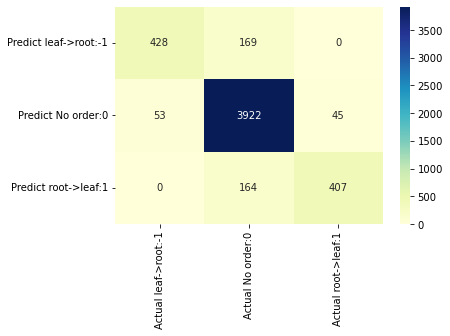

In [23]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.89      0.72      0.79       597
           0       0.92      0.98      0.95      4020
           1       0.90      0.71      0.80       571

    accuracy                           0.92      5188
   macro avg       0.90      0.80      0.85      5188
weighted avg       0.92      0.92      0.91      5188



##### Saving Best Classifier

In [25]:
pickle.dump(best_model, open("Models/GBM_Ternaryclassifier_Pretrained.pkl", "wb"))

##### Only using Metrics

In [80]:
processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2", 'sentence_vector_embedding_1', 'sentence_vector_embedding_2']).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=["label"]), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [81]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [82]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8113701739724755

In [83]:
best_model = gsearch1.best_estimator_

In [84]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [85]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


###### Performance analysis on test dataset

In [86]:
y_pred=best_model.predict(X_test)
y_pred

array([ 1,  0, -1, ...,  1,  0,  0])

In [87]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8410


Text(0, 0.5, 'Feature Importance Score')

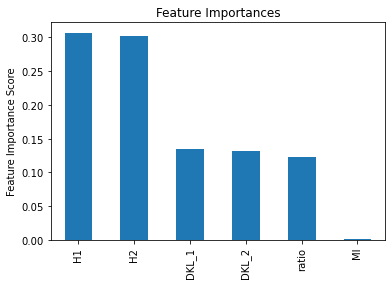

In [92]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Observations des variables importantes beaucoup plus cohérentes avec l'asymétrie requise pour comprendre la relation d'ordre. D_KL + Entropie sont utiles.

Plot confusion matrix

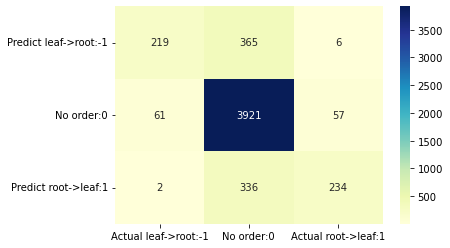

In [88]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.37      0.50       590
           0       0.85      0.97      0.91      4039
           1       0.79      0.41      0.54       572

    accuracy                           0.84      5201
   macro avg       0.80      0.58      0.65      5201
weighted avg       0.83      0.84      0.82      5201



Perte de performance avec cette reduction de dimension grâce aux metriques de l'information mutuelle.<br>
Mon hypothèse est qu'avec des plongements probabiliste comme GLoVe, ces métriques là marcheraient mieux. L'idéal serait d'avoir une métrique de cooccurence comme GLoVe, mais qui produisent des embeddings pour des mots qui ne sont pas dans le vocabulaire comme FastText.

#### Only on -1 and 1 labels

In [13]:
labeled_minus1_1_concept_pair_df = labeled_concept_pair_df[labeled_concept_pair_df.label.isin([-1,1])]
labeled_minus1_1_concept_pair_df.describe()

,label
count,5980.000000
mean,0.002007
std,1.000082
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


##### Only using Metrics

In [91]:
processed_data = labeled_minus1_1_concept_pair_df.drop(columns=["kw1", "kw2", 'sentence_vector_embedding_1', 'sentence_vector_embedding_2']).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=["label"]), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [93]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [94]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8068248181920745

In [95]:
best_model = gsearch1.best_estimator_

In [96]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [97]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [98]:
y_pred=best_model.predict(X_test)
y_pred

array([-1, -1,  1, ..., -1, -1,  1])

In [99]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8311


Text(0, 0.5, 'Feature Importance Score')

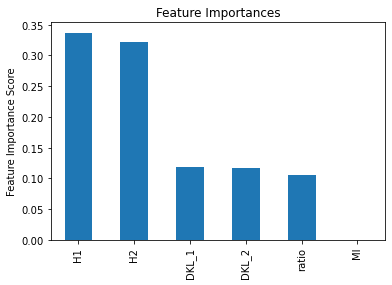

In [100]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

<AxesSubplot:>

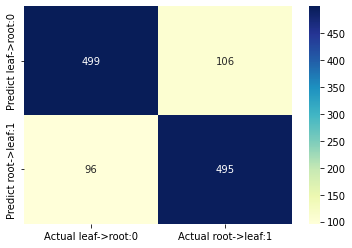

In [101]:
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.82      0.83       605
           1       0.82      0.84      0.83       591

    accuracy                           0.83      1196
   macro avg       0.83      0.83      0.83      1196
weighted avg       0.83      0.83      0.83      1196



#### Only on 0 and 1 labels

##### Only using embeddings

In [26]:
processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2", 'H1', 'H2', 'DKL_1', 'DKL_2', 'ratio'])#.dropna(subset="ratio")

processed_data['label'] = processed_data['label'].replace(-1, 0)## Replaces the -1 with zeros

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(training_data_embedding, processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [27]:
processed_data['label'].describe()

count    25939.000000
mean         0.114615
std          0.318563
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64

In [28]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [29]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9468883226421256

In [30]:
best_model = gsearch1.best_estimator_

In [31]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [32]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


###### Performance analysis on test dataset

In [33]:
best_model = gsearch1.best_estimator_
y_pred=best_model.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 0, 0])

In [34]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9572


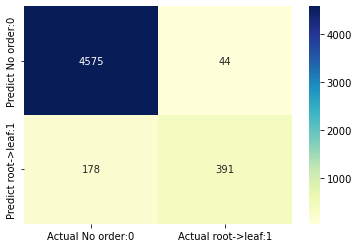

In [35]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4619
           1       0.90      0.69      0.78       569

    accuracy                           0.96      5188
   macro avg       0.93      0.84      0.88      5188
weighted avg       0.96      0.96      0.95      5188



##### Saving Best Classifier

In [48]:
pickle.dump(best_model, open("Models/naive_gridsearch_01_classifier.pkl", "wb"))

## FastText Classification

#### Preparing the Data for Experiment
This sections is inspired by [this](https://towardsdatascience.com/fasttext-for-text-classification-a4b38cbff27c).<br><br>

FastText expects the **category first**, with the prefix `__label__` before each category, and then the input text, like so,<br>

*ex:* __label__positive I really enjoyed this restaurant. Would love to visit again.

In [3]:
def PrepareDFforFastText(kw1, kw2, label):
    return ('__label__'+str(label), ", ".join([kw1, kw2]))

In [6]:
## Testing implementation
test_obj = {}
test_obj["kw1"] = "object oriented programming"
test_obj["kw2"] = "machine learning"
test_obj["label"] = -1


PrepareDFforFastText(**test_obj)

('__label__-1', 'object oriented programming, machine learning')

In [14]:
FastText_df = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: PrepareDFforFastText(x.kw1, x.kw2, x.label), axis=1, result_type="expand"))
FastText_df.tail()

,0,1
25934,__label__0,"software testing debugging, combinational synt..."
25935,__label__0,"combinational synthesis, power management"
25936,__label__0,"software fault tolerance, pcb design layout"
25937,__label__0,"pcb design layout, formal method"
25938,__label__0,"documentation, pcb design layout"


In [16]:
train_df = FastText_df.sample(frac=0.8,random_state=200) #random state is a seed value
test_df  = FastText_df.drop(train_df.index)

##### Sanity Check

In [57]:
## Does the 80-10-10 holds up in testing set?
y_test = test_df.iloc[:,0].apply(lambda x: int(x.split("__label__")[1]))
y_test.value_counts()

 0    4024
 1     597
-1     567
Name: 0, dtype: int64

In [58]:
## Does the 80-10-10 holds up in training set?
y_train = train_df.iloc[:,0].apply(lambda x: int(x.split("__label__")[1]))
y_train.value_counts()

 0    15997
-1     2378
 1     2376
Name: 0, dtype: int64

In [29]:
train_df.tail()

,0,1
14175,__label__0,"computing platform, command control language"
24867,__label__0,"process validation, data recovery"
24455,__label__0,"learning management system, neural system"
16221,__label__0,"semantic network, cyber-physical network"
978,__label__1,"information system application, reputation system"


##### Saving The training and Testing data

In [31]:
import csv
train_df.to_csv('Data/FastTextData/train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

test_df.to_csv('Data/FastTextData/test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")

### Training FastText Model

We are using 2M pretrained word vectors on Common Crawl that you can get from [here](https://fasttext.cc/docs/en/english-vectors.html).

In [33]:
model = fasttext.train_supervised(input="Data/FastTextData/train.txt", dim=300, lr=1.0, epoch=25, wordNgrams=2, pretrainedVectors="Data/FastTextData/crawl-300d-2M.vec")

Read 0M words
Number of words:  2127
Number of labels: 3
Progress: 100.0% words/sec/thread:  698370 lr:  0.000000 avg.loss:  0.344960 ETA:   0h 0m 0s


#### Analyzing Performance on Test Data

In [34]:
# Evaluating performance on the entire test file
model.test('Data/FastTextData/test.txt')             

(5188, 0.8608326908249807, 0.8608326908249807)

In [80]:
y_pred = [ExtractIntLabelFromPred(model.predict(el)) for el in test_df.iloc[:, 1]]

<AxesSubplot:>

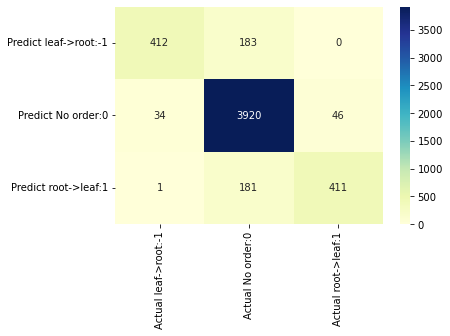

In [32]:
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.64      0.69       567
           0       0.90      0.92      0.91      4024
           1       0.65      0.64      0.65       597

    accuracy                           0.86      5188
   macro avg       0.77      0.74      0.75      5188
weighted avg       0.86      0.86      0.86      5188



#### Testing on intuitive examples
Testing on out distribution data from our tree.

In [71]:
model.predict("machine learning, k-means clustering")

(('__label__1',), array([1.00001001]))

In [72]:
model.predict("k-means clustering, machine learning")

(('__label__-1',), array([1.00001001]))

In [74]:
model.predict("k-nearest neighbors, machine learning")

(('__label__-1',), array([1.00001001]))

In [75]:
model.predict("unsupervised learning, machine learning")## Error should be -1

(('__label__1',), array([1.00001001]))

In [76]:
model.predict("supervised learning, machine learning")

(('__label__-1',), array([1.00001001]))

In [78]:
model.predict("linear regression, supervised learning")

(('__label__-1',), array([1.00001001]))

#### Saving FastText Model

In [ ]:
# Save the trained model
model.save_model('Models/Trained_FastText_model.bin')

## Building Directed Graph from a Relation

#### Loading models

In [3]:
model = fasttext.load_model('Models/Trained_FastText_model.bin')

In [4]:
ft_model = fasttext.load_model('Models/cc.en.300.bin')

In [12]:
'unsupervised' in ft_model

True

In [6]:
best_model = pickle.load(open("Models/naive_gridsearch_classifier.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

### Computing graph based on trained models

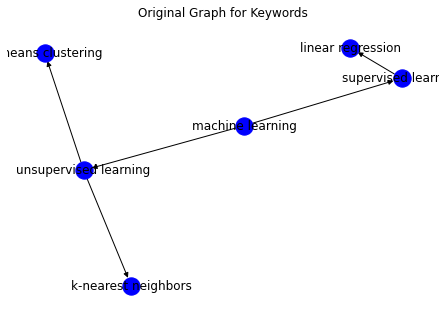

In [82]:
import networkx as nx
from Scripts.graphgeneration import BuildRelationList, BuildGraphDictFromRelationList, gbm_classifier

## Building the ground truth graph
given_kw_list = ["machine learning", "k-means clustering", "k-nearest neighbors", "unsupervised learning", "supervised learning", "linear regression"]
relationList = [("machine learning", "supervised learning", 1), ("machine learning", "unsupervised learning", 1), ("linear regression", "supervised learning", -1), ("k-means clustering", "unsupervised learning", -1), ("unsupervised learning", "k-nearest neighbors", 1)]

ogG = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

pos = nx.spring_layout(ogG)

nx.draw(ogG, pos=pos, with_labels = True, node_color = 'b')
plt.title("Original Graph for Keywords")
plt.show()

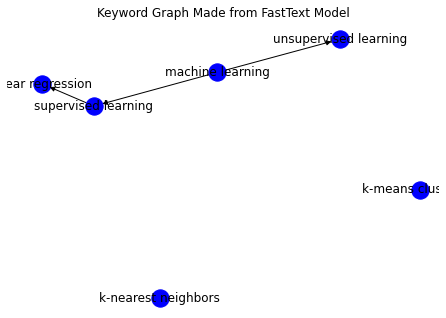

In [86]:
kw_pairs = [("unsupervised learning", "k-means clustering"), ("k-nearest neighbors", "unsupervised learning"), ("machine learning", "supervised learning"), ("machine learning", "unsupervised learning"), ("linear regression", "supervised learning"), ("k-means clustering", "unsupervised learning"), ("unsupervised learning", "k-nearest neighbors")]

relationList = BuildRelationList(kw_pairs, [", ".join(pair) for pair in kw_pairs], lambda x: ExtractIntLabelFromPred(model.predict(x)))

ftG = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

pos = nx.spring_layout(ftG)

nx.draw(ftG, pos=pos, with_labels = True, node_color = 'b')
plt.title("Keyword Graph Made from FastText Model")
plt.show()


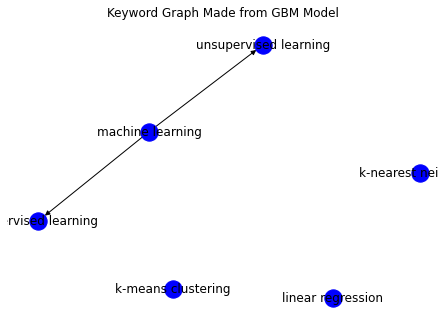

In [87]:
relationList = BuildRelationList(kw_pairs, kw_pairs, lambda x: gbm_classifier(ft_model.get_sentence_vector, best_model.predict, x))

gbmG = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

pos = nx.spring_layout(gbmG)

nx.draw(gbmG, pos=pos, with_labels = True, node_color = 'b')
plt.title("Keyword Graph Made from GBM Model")
plt.show()


#### Comparing Created Graphs to the original Graph 

In [89]:
print("Edit distance between the og Graph and the gbm Graph:", nx.graph_edit_distance(ogG, gbmG))
print("Edit distance between the og Graph and the FastTextModel Graph:", nx.graph_edit_distance(ogG, ftG))

Edit distance between the og Graph and the gbm Graph: 3.0
Edit distance between the og Graph and the FastTextModel Graph: 2.0


It comes without any surprise that the graph built with the FastText Model is closer to the ground truth given the graphical results in the section `Computing graph based on trained models`.

It is interesting to this experiment on a larger scale of out of distribution data.